In [48]:
# VISUALISING THE POSITIONS OF ROBOTS AND TASKS

def visual(m,n,title,allocation,failure):
    
    %matplotlib inline
    import matplotlib.pyplot as plt


    R_P= {"x":[], "y":[], "label":[]}
    for p, q in m.items():
        R_P["x"].append(q[0])
        R_P["y"].append(q[1])
        R_P["label"].append(p)
    
    
    T_P = {"a":[], "b":[], "label_1":[]}
    for r, s in n.items():
        T_P["a"].append(s[0])
        T_P["b"].append(s[1])
        T_P["label_1"].append(r)

    # DISPLAY SCATTER PLOT DATA
    
    plt.figure(figsize=(20,10))
    plt.title(title, fontsize=20)
    plt.xlabel('X AXIS', fontsize=20)
    plt.ylabel('Y AXIS', fontsize=20)
    
    a = plt.scatter(R_P["x"], R_P["y"], color = 'red',marker = 'o', s=80,label='Robots')
    b = plt.scatter(T_P["a"], T_P["b"], color = 'blue',marker = 'o', s=80,label='Tasks')
    plt.legend(handles = [a,b])
    
    # ADDING LABELS
    
    for label, x, y in zip(R_P["label"], R_P["x"], R_P["y"]):
        plt.annotate(label, xy  = (x, y),size = 20)


    for label_1, a, b in zip(T_P["label_1"], T_P["a"], T_P["b"]):
        plt.annotate(label_1, xy  = (a, b),size = 20)
        
    # ALLOCATION GRAPH....
    
    if len(allocation) > 0:    
        for i,j in zip(allocation,m.values()):
            x_values = [i[0], j[0]]
            y_values = [i[1], j[1]]
            plt.plot(x_values, y_values,linewidth=2)
    
    # IF FAILURE EXISTS....
        
    if len(failure) > 0:
        x_values = []
        y_values = []
        for i,j in zip(failure[0],failure[1]):
            x_values = [i[0],j[0]]
            y_values = [i[1],j[1]]
            plt.plot(x_values, y_values,linewidth=2)
        
    plt.show()

    


In [49]:
                                                     # MOPSO

    
def pso(m,n,pc,d,e,bc,dist_travel,failure):
    
# m = ROBOTS ; n = TASKS ; pc = PROCESSING CAPACITY OF TASKS ; d & e = TITLES FOR GRAPH ; bc = BATTERY RATE AFTER ALLOCATION
# dist_travel = TOTAL DISTANCE TRAVELLED AFTER ALLOCATION
    
        # IMPORTING ALL THE NECESSARY LIBRARIES
        
        import time
        import random
        import numpy
        from operator import add
        from scipy.spatial import distance
        from itertools import permutations
        %matplotlib inline
        import matplotlib.pyplot as plt
        
        # STARTING THE TIMER

        start = time.time()
        
        # PLOTTING THE GRAPH OF ROBOTS AND TASKS POSITION IN A 2-D SPACE
        
        #visual(m,n,d,allocation = [],failure = [])
        
        # NO.OF TASKS (count) AND TASK NUMBERS (Tasks)
        
        Tasks = []
        count = 0
        for i in n.keys():
            Tasks.append(i)
            count+=1

        # COST FUNCTION

        def euclidean_distance(a,b):
            d = distance.euclidean(a,b)
            return d

        # DISTANCE UTILITY MATRIX

        # 10 * 10 MATRIX
        
        location = {}
        keys = range(0,count)
        for i in keys:
                location[i] =[]

        for i in n.values():
            for k,j in m.items():
                location[k].append(euclidean_distance(j,i))

        global dist_mat
        dist_mat = numpy.array([location[i] for i in location.keys()])


        # BATTERY UTILITY MATRIX (MOVING + PROCESSING)

        # 10 * 10 MATRIX

        # MOVING CAPACITY : ASSUMING THE BATTERY CAPACITY OF ROBOTS ARE 100% INITIALLY...

        # FOR EVERY 0.1m IT TRAVELS, 3 % OF BATTERY REDUCES...

        # MAX.TRAVEL = 3.33 m = 100 % = 1

        moving_capacity = {}
        keys = range(0,count)
        for i in keys:
                moving_capacity[i] =[]

        k = 0
        for a in range(0,count): 
            x = 0
            for i in location.values():
                h = (i[k] * 3) / 0.1
                moving_capacity[x].append(h/100)
                x+=1
            k+=1

        global battery_mat
        battery_mat = []
        for i in moving_capacity.values():
            battery_mat.append(list(map(add, i, pc))) 
            x+=1


        # FINAL UTILITY MATRIX

        global utility
        utility = {}
        keys = range(0,count)

        u = []
        for i in zip(dist_mat,battery_mat):
            u.append(sum(i))

        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        u = scaler.fit_transform(u)

        x = 0
        for i in u:
            utility[x] = i
            x+=1
        

        # PARTICLE GENERATION

        particles = []
        for i in range(0,100):
            particles.append(random.sample(Tasks,count))
    


        # VELOCITY INITIALISATION
        
        vel = [0] * count
        velocity = []
        for i in range(0,100):
            velocity.append(random.sample(vel,count))
    


        # CALCULATING THE FITNESS OF PARTICLES USING THE UTILITY MATRIX

        Fitness = []
        for k in range(0,100):
            x = 0
            cost = []
            for i in range (0,count):
                cost.append(utility[i][particles[k][x]])
                x+=1
            Fitness.append(sum(cost))
    


        # INITIALISING P_BEST, P_BEST FITNESS, G_BEST (FITNESS VALUE, INDEX VALUE, POSITION)

        p_best = particles
        p_best_fitness = Fitness

        global G_BEST
        G_BEST = []
        g_best = numpy.min(Fitness)
        g_best_index = numpy.argmin(Fitness)
        g_best_position = p_best[g_best_index]
        G_BEST.append(g_best)
        
        #print('The Allocation of Tasks to the Robots in 1ST ITERATION is given as {}'.format(g_best_position))
        #print('The G_best value is {} for 1ST ITERATION'.format(g_best))


        # UPDATING THE VELOCITIES OF EACH PARTICLE

        particle_velocity = {}
        keys = range(0,100)
        for i in keys:
                particle_velocity[i] =[]
                
        c1 = c2 = 2
        w = 0.9
        x = 0
        for i in range(0,count):
            a = 0
            for k,i,p in zip(particles,velocity,p_best):
                r1=random.random()
                r2=random.random()
                vel_cognitive = c1 * r1 * (p[x]-k[x])
                vel_social = c2 * r2 * (g_best_position[x]-k[x])
                particle_velocity[a].append(w * i[x] + vel_cognitive + vel_social)
                a+=1
            x+=1
       

        # UPDATING THE POSITIONS OF EACH PARTICLE
        
        particle_position = {}
        keys = range(0,100)
        for i in keys:
                particle_position[i] =[]
                
        x = 0        
        for i in range(0,count):
            y =0
            for i,j in zip(particles, particle_velocity.values()):
                h = int(round(i[x]+j[x]))
                particle_position[y].append(h)   
                y+=1
            x+=1

        new_particles = []   
        for a in particle_position.values():
            c = []
            for i in a:
                if i >= count or i < 0:
                    for j in Tasks:
                        if j not in a:
                            if j not in c:
                                i = j
                                break
                            else:
                                continue
                    c.append(i)
                elif i in c:
                    for j in Tasks:
                        if j not in a:
                            if j not in c:
                                i = j
                                break
                            else:
                                continue
                    c.append(i)
                else:
                    c.append(i)
            new_particles.append(c)
       
            
        # UPDATING THE PARTICLE POSITION, VELOCITY AND P_BEST FOR NEXT ITERATIONS

        old_particles = p_best
        particles = []
        particles = new_particles
        velocity = {}
        velocity = particle_velocity

# ********************************************* ITERATION BEGINS *******************************************************

        for t in range(1,2001):

            # INERTIAL WEIGHT

            w_max = 0.9
            w_min = 0.4
            maxIt = 1500
            k = w_max - w_min
            p = t / maxIt
            w = w_max - (p * k)
            

            # FITNESS OF PARTICLES

            fitness = []
            for k in range(0,100):
                x = 0
                cost = []
                for i in range (0,count):
                    cost.append(utility[i][particles[k][x]])
                    x+=1
                fitness.append(sum(cost))

            # FINDING THE PBEST

            p_best = []
            x = 0
            for i,j in zip(old_particles,particles):
                if fitness[x] < p_best_fitness[x]:
                    p_best.append(j)
                else:
                    p_best.append(i)   
                x+=1

            # FINDING P_BEST FITNESS 

            Fitness = []
            for i,j in zip(fitness, p_best_fitness):
                if i < j:
                    Fitness.append(i)
                else:
                    Fitness.append(j)
            p_best_fitness = Fitness   
    

            # UPDATING G_BEST (FITNESS VALUE, INDEX VALUE, POSITION)
        
            g_best = numpy.min(Fitness)
            g_best_index = numpy.argmin(Fitness)
            g_best_position = p_best[g_best_index]

            G_BEST.append(g_best)

            #print('The Allocation of Tasks to the Robots is given as {}'.format(g_best_position))
            #print('The G_best is {} for {}th iteration'.format(g_best,t))


            # UPDATING THE VELOCITIES OF EACH PARTICLE

            particle_velocity = {}
            keys = range(0,100)
            for i in keys:
                    particle_velocity[i] =[]

            c1 = 0.5
            c2 = 2
            x = 0
            for i in range(0,count):
                a = 0
                for k,i,p in zip(particles,velocity.values(),p_best):
                    r1=random.random()
                    r2=random.random()
                    vel_cognitive = c1 * r1 * (p[x]-k[x])
                    vel_social = c2 * r2 * (g_best_position[x]-k[x])
                    particle_velocity[a].append(w * i[x] + vel_cognitive + vel_social)
                    a+=1
                x+=1

            # UPDATING THE POSITIONS OF EACH PARTICLE

            particle_position = {}
            keys = range(0,100)
            for i in keys:
                    particle_position[i] =[]

            x = 0        
            for i in range(0,count):
                y = 0
                for i,j in zip(particles, particle_velocity.values()):
                    h = int(i[x]+j[x])
                    particle_position[y].append(h)   
                    y+=1
                x+=1

            new_particles = []   
            for a in particle_position.values():
                c = []
                for i in a:
                    if i >= count or i < 0:
                        for j in Tasks:
                            if j not in a:
                                if j not in c:
                                    i = j
                                    break
                                else:
                                    continue
                        c.append(i)
                    elif i in c:
                        for j in Tasks:
                            if j not in a:
                                if j not in c:
                                    i = j
                                    break
                                else:
                                    continue
                        c.append(i)
                    else:
                        c.append(i)
                new_particles.append(c)

            # UPDATING THE PARTICLE POSITION, VELOCITY AND P_BEST FOR NEXT ITERATIONS

            old_particles = p_best
            particles = []
            particles = new_particles
            velocity = {}
            velocity = particle_velocity
            
    
# ************************************************* ITERATION ENDS ************************************************************


        print('\n\nThe BEST Allocation of Tasks to the Robots is given as {}'.format(g_best_position))
        print('MOPSO {} for {}th iteration'.format(g_best,t))
        


        end = time.time()
        print("\nExecution time is {} seconds".format(end-start))
        #print('\nALLOCATION COMPLETED !!!')

        #  PLOTTING THE GRAPH OF TASK ALLOCATION 

        allocation = []
        for i in g_best_position:
            for a,b in n.items():
                    if i == a:
                        allocation.append(b)            
        # visual(m,n,e,allocation,failure = [])
        
        global  battery_capacity
        battery_capacity = []
        x = 0
        for i in g_best_position:
            c = battery_mat[x][i]
            battery_capacity.append(bc[x]-c)
            x+=1
          
        print('\nBATTERY RATE OF THE ROBOTS NOW IS AS FOLLOWS  \n\n{}'.format(battery_capacity))
        
     
            
#*****************************************************************************************************************************

In [50]:
                                                    # PSO

    
def pso1(m,n,pc,d,e,bc,dist_travel,failure):
    
# m = ROBOTS ; n = TASKS ; pc = PROCESSING CAPACITY OF TASKS ; d & e = TITLES FOR GRAPH ; bc = BATTERY RATE AFTER ALLOCATION
# dist_travel = TOTAL DISTANCE TRAVELLED AFTER ALLOCATION
    
        # IMPORTING ALL THE NECESSARY LIBRARIES
        
        import time
        import random
        import numpy
        from operator import add
        from scipy.spatial import distance
        from itertools import permutations
        %matplotlib inline
        import matplotlib.pyplot as plt
        
        # STARTING THE TIMER

        start = time.time()
        
        # PLOTTING THE GRAPH OF ROBOTS AND TASKS POSITION IN A 2-D SPACE
        
        #visual(m,n,d,allocation = [],failure = [])
        
        # NO.OF TASKS (count) AND TASK NUMBERS (Tasks)
        
        Tasks = []
        count = 0
        for i in n.keys():
            Tasks.append(i)
            count+=1

        # COST FUNCTION

        def euclidean_distance(a,b):
            d = distance.euclidean(a,b)
            return d

        # DISTANCE UTILITY MATRIX

        # 10 * 10 MATRIX
        
        location = {}
        keys = range(0,count)
        for i in keys:
                location[i] =[]

        for i in n.values():
            for k,j in m.items():
                location[k].append(euclidean_distance(j,i))

        global dist_mat
        dist_mat = numpy.array([location[i] for i in location.keys()])


        # BATTERY UTILITY MATRIX (MOVING + PROCESSING)

        # 10 * 10 MATRIX

        # MOVING CAPACITY : ASSUMING THE BATTERY CAPACITY OF ROBOTS ARE 100% INITIALLY...

        # FOR EVERY 0.1m IT TRAVELS, 3 % OF BATTERY REDUCES...

        # MAX.TRAVEL = 3.33 m = 100 % = 1

        moving_capacity = {}
        keys = range(0,count)
        for i in keys:
                moving_capacity[i] =[]

        k = 0
        for a in range(0,count): 
            x = 0
            for i in location.values():
                h = (i[k] * 3) / 0.1
                moving_capacity[x].append(h/100)
                x+=1
            k+=1

        global battery_mat
        battery_mat = []
        for i in moving_capacity.values():
            battery_mat.append(list(map(add, i, pc))) 
            x+=1


        # FINAL UTILITY MATRIX

        global utility
        utility = {}
        keys = range(0,count)

        u = []
        for i in zip(dist_mat,battery_mat):
            u.append(sum(i))

        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        u = scaler.fit_transform(u)

        x = 0
        for i in u:
            utility[x] = i
            x+=1
        

        # PARTICLE GENERATION

        particles = []
        for i in range(0,100):
            particles.append(random.sample(Tasks,count))
    


        # VELOCITY INITIALISATION
        
        vel = [0] * count
        velocity = []
        for i in range(0,100):
            velocity.append(random.sample(vel,count))
    


        # CALCULATING THE FITNESS OF PARTICLES USING THE UTILITY MATRIX

        Fitness = []
        for k in range(0,100):
            x = 0
            cost = []
            for i in range (0,count):
                cost.append(utility[i][particles[k][x]])
                x+=1
            Fitness.append(sum(cost))
    


        # INITIALISING P_BEST, P_BEST FITNESS, G_BEST (FITNESS VALUE, INDEX VALUE, POSITION)

        p_best = particles
        p_best_fitness = Fitness

        global G_BEST2
        G_BEST2 = []
        g_best = numpy.min(Fitness)
        g_best_index = numpy.argmin(Fitness)
        g_best_position = p_best[g_best_index]
        G_BEST2.append(g_best)
        
        #print('The Allocation of Tasks to the Robots in 1ST ITERATION is given as {}'.format(g_best_position))
        #print('The G_best value is {} for 1ST ITERATION'.format(g_best))


        # UPDATING THE VELOCITIES OF EACH PARTICLE

        particle_velocity = {}
        keys = range(0,100)
        for i in keys:
                particle_velocity[i] =[]
                
        c1 = c2 = 2
        w = 0.9
        x = 0
        for i in range(0,count):
            a = 0
            for k,i,p in zip(particles,velocity,p_best):
                r1=random.random()
                r2=random.random()
                vel_cognitive = c1 * r1 * (p[x]-k[x])
                vel_social = c2 * r2 * (g_best_position[x]-k[x])
                particle_velocity[a].append(w * i[x] + vel_cognitive + vel_social)
                a+=1
            x+=1
       

        # UPDATING THE POSITIONS OF EACH PARTICLE
        
        particle_position = {}
        keys = range(0,100)
        for i in keys:
                particle_position[i] =[]
                
        x = 0        
        for i in range(0,count):
            y =0
            for i,j in zip(particles, particle_velocity.values()):
                h = int(round(i[x]+j[x]))
                particle_position[y].append(h)   
                y+=1
            x+=1

        new_particles = []   
        for a in particle_position.values():
            c = []
            for i in a:
                if i >= count or i < 0:
                    for j in Tasks:
                        if j not in a:
                            if j not in c:
                                i = j
                                break
                            else:
                                continue
                    c.append(i)
                elif i in c:
                    for j in Tasks:
                        if j not in a:
                            if j not in c:
                                i = j
                                break
                            else:
                                continue
                    c.append(i)
                else:
                    c.append(i)
            new_particles.append(c)
       
            
        # UPDATING THE PARTICLE POSITION, VELOCITY AND P_BEST FOR NEXT ITERATIONS

        old_particles = p_best
        particles = []
        particles = new_particles
        velocity = {}
        velocity = particle_velocity

# ********************************************* ITERATION BEGINS *******************************************************

        for t in range(1,2001):
            

            # FITNESS OF PARTICLES

            fitness = []
            for k in range(0,100):
                x = 0
                cost = []
                for i in range (0,count):
                    cost.append(utility[i][particles[k][x]])
                    x+=1
                fitness.append(sum(cost))

            # FINDING THE PBEST

            p_best = []
            x = 0
            for i,j in zip(old_particles,particles):
                if fitness[x] < p_best_fitness[x]:
                    p_best.append(j)
                else:
                    p_best.append(i)   
                x+=1

            # FINDING P_BEST FITNESS 

            Fitness = []
            for i,j in zip(fitness, p_best_fitness):
                if i < j:
                    Fitness.append(i)
                else:
                    Fitness.append(j)
            p_best_fitness = Fitness   
    

            # UPDATING G_BEST (FITNESS VALUE, INDEX VALUE, POSITION)
        
            g_best = numpy.min(Fitness)
            g_best_index = numpy.argmin(Fitness)
            g_best_position = p_best[g_best_index]

            G_BEST2.append(g_best)

            #print('The Allocation of Tasks to the Robots is given as {}'.format(g_best_position))
            #print('The G_best is {} for {}th iteration'.format(g_best,t))


            # UPDATING THE VELOCITIES OF EACH PARTICLE

            particle_velocity = {}
            keys = range(0,100)
            for i in keys:
                    particle_velocity[i] =[]

            c1 = c2 = 2
            x = 0
            w = 0.9
            for i in range(0,count):
                a = 0
                for k,i,p in zip(particles,velocity.values(),p_best):
                    r1=random.random()
                    r2=random.random()
                    vel_cognitive = c1 * r1 * (p[x]-k[x])
                    vel_social = c2 * r2 * (g_best_position[x]-k[x])
                    particle_velocity[a].append(w * i[x] + vel_cognitive + vel_social)
                    a+=1
                x+=1

            # UPDATING THE POSITIONS OF EACH PARTICLE

            particle_position = {}
            keys = range(0,100)
            for i in keys:
                    particle_position[i] =[]

            x = 0        
            for i in range(0,count):
                y = 0
                for i,j in zip(particles, particle_velocity.values()):
                    h = int(i[x]+j[x])
                    particle_position[y].append(h)   
                    y+=1
                x+=1

            new_particles = []   
            for a in particle_position.values():
                c = []
                for i in a:
                    if i >= count or i < 0:
                        for j in Tasks:
                            if j not in a:
                                if j not in c:
                                    i = j
                                    break
                                else:
                                    continue
                        c.append(i)
                    elif i in c:
                        for j in Tasks:
                            if j not in a:
                                if j not in c:
                                    i = j
                                    break
                                else:
                                    continue
                        c.append(i)
                    else:
                        c.append(i)
                new_particles.append(c)

            # UPDATING THE PARTICLE POSITION, VELOCITY AND P_BEST FOR NEXT ITERATIONS

            old_particles = p_best
            particles = []
            particles = new_particles
            velocity = {}
            velocity = particle_velocity
            
    
# ************************************************* ITERATION ENDS ************************************************************


        print('\n\nThe BEST Allocation of Tasks to the Robots is given as {}'.format(g_best_position))
        print('SPSO {} for {}th iteration'.format(g_best,t))
        


        end = time.time()
        print("\nExecution time is {} seconds".format(end -start))
        #print('\nALLOCATION COMPLETED !!!')

        #  PLOTTING THE GRAPH OF TASK ALLOCATION 

        allocation = []
        for i in g_best_position:
            for a,b in n.items():
                    if i == a:
                        allocation.append(b)            
        # visual(m,n,e,allocation,failure = [])
        
        global distance_travelled
        ds = []
        x = 0
        for i in g_best_position:
            c = dist_mat[x][i]
            ds.append(c)
            x+=1
                
        distance_travelled = []
        for i,j in zip(dist_travel, ds):
            distance_travelled.append(i+j)
            
        #print('\nDISTANCE TRAVELLED BY THE ROBOTS IS AS FOLLOWS (In metres)  \n\n{}'.format(distance_travelled))
            
        global  battery_capacity
        battery_capacity = []
        x = 0
        for i in g_best_position:
            c = battery_mat[x][i]
            battery_capacity.append(bc[x]-c)
            x+=1
          
        print('\nBATTERY RATE OF THE ROBOTS NOW IS AS FOLLOWS  \n\n{}'.format(battery_capacity))

           
        

In [60]:
                                                    # PSO - C

    
def pso2(m,n,pc,d,e,bc,dist_travel,failure):
    
# m = ROBOTS ; n = TASKS ; pc = PROCESSING CAPACITY OF TASKS ; d & e = TITLES FOR GRAPH ; bc = BATTERY RATE AFTER ALLOCATION
# dist_travel = TOTAL DISTANCE TRAVELLED AFTER ALLOCATION
    
        # IMPORTING ALL THE NECESSARY LIBRARIES
        
        import time
        import cmath
        import random
        import numpy
        from operator import add
        from scipy.spatial import distance
        from itertools import permutations
        %matplotlib inline
        import matplotlib.pyplot as plt
        
        # STARTING THE TIMER

        start = time.time()
        
        # PLOTTING THE GRAPH OF ROBOTS AND TASKS POSITION IN A 2-D SPACE
        
        #visual(m,n,d,allocation = [],failure = [])
        
        # NO.OF TASKS (count) AND TASK NUMBERS (Tasks)
        
        Tasks = []
        count = 0
        for i in n.keys():
            Tasks.append(i)
            count+=1

        # COST FUNCTION

        def euclidean_distance(a,b):
            d = distance.euclidean(a,b)
            return d

        # DISTANCE UTILITY MATRIX

        # 10 * 10 MATRIX
        
        location = {}
        keys = range(0,count)
        for i in keys:
                location[i] =[]

        for i in n.values():
            for k,j in m.items():
                location[k].append(euclidean_distance(j,i))

        global dist_mat
        dist_mat = numpy.array([location[i] for i in location.keys()])


        # BATTERY UTILITY MATRIX (MOVING + PROCESSING)

        # 10 * 10 MATRIX

        # MOVING CAPACITY : ASSUMING THE BATTERY CAPACITY OF ROBOTS ARE 100% INITIALLY...

        # FOR EVERY 0.1m IT TRAVELS, 3 % OF BATTERY REDUCES...

        # MAX.TRAVEL = 3.33 m = 100 % = 1

        moving_capacity = {}
        keys = range(0,count)
        for i in keys:
                moving_capacity[i] =[]

        k = 0
        for a in range(0,count): 
            x = 0
            for i in location.values():
                h = (i[k] * 3) / 0.1
                moving_capacity[x].append(h/100)
                x+=1
            k+=1

        global battery_mat
        battery_mat = []
        for i in moving_capacity.values():
            battery_mat.append(list(map(add, i, pc))) 
            x+=1


        # FINAL UTILITY MATRIX

        global utility
        utility = {}
        keys = range(0,count)

        u = []
        for i in zip(dist_mat,battery_mat):
            u.append(sum(i))

        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        u = scaler.fit_transform(u)

        x = 0
        for i in u:
            utility[x] = i
            x+=1
        

        # PARTICLE GENERATION

        particles = []
        for i in range(0,100):
            particles.append(random.sample(Tasks,count))
    


        # VELOCITY INITIALISATION
        
        vel = [0] * count
        velocity = []
        for i in range(0,100):
            velocity.append(random.sample(vel,count))
    


        # CALCULATING THE FITNESS OF PARTICLES USING THE UTILITY MATRIX

        Fitness = []
        for k in range(0,100):
            x = 0
            cost = []
            for i in range (0,count):
                cost.append(utility[i][particles[k][x]])
                x+=1
            Fitness.append(sum(cost))
    


        # INITIALISING P_BEST, P_BEST FITNESS, G_BEST (FITNESS VALUE, INDEX VALUE, POSITION)

        p_best = particles
        p_best_fitness = Fitness

        global G_BEST3
        G_BEST3 = []
        g_best = numpy.min(Fitness)
        g_best_index = numpy.argmin(Fitness)
        g_best_position = p_best[g_best_index]
        G_BEST3.append(g_best)
        
        #print('The Allocation of Tasks to the Robots in 1ST ITERATION is given as {}'.format(g_best_position))
        #print('The G_best value is {} for 1ST ITERATION'.format(g_best))


        # UPDATING THE VELOCITIES OF EACH PARTICLE

        particle_velocity = {}
        keys = range(0,100)
        for i in keys:
            particle_velocity[i] =[]

        c1 = c2 = 2.05
        x = 0
        for i in range(0,count):
            a = 0
            for k,i,p in zip(particles,velocity,p_best):
                r1=random.random()
                r2=random.random()
                phi = c1 + c2
                root = cmath.sqrt((phi**2) - 4*phi)
                ki = (2 / (2 - phi - abs(root)))
                vel_cognitive = c1 * r1 * (p[x]-k[x])
                vel_social = c2 * r2 * (g_best_position[x]-k[x])
                particle_velocity[a].append(abs(ki) * (i[x] + vel_cognitive + vel_social))
                a+=1
            x+=1
       

        # UPDATING THE POSITIONS OF EACH PARTICLE
        
        particle_position = {}
        keys = range(0,100)
        for i in keys:
                particle_position[i] =[]
                
        x = 0        
        for i in range(0,count):
            y =0
            for i,j in zip(particles, particle_velocity.values()):
                h = int(round(i[x]+j[x]))
                particle_position[y].append(h)   
                y+=1
            x+=1

        new_particles = []   
        for a in particle_position.values():
            c = []
            for i in a:
                if i >= count or i < 0:
                    for j in Tasks:
                        if j not in a:
                            if j not in c:
                                i = j
                                break
                            else:
                                continue
                    c.append(i)
                elif i in c:
                    for j in Tasks:
                        if j not in a:
                            if j not in c:
                                i = j
                                break
                            else:
                                continue
                    c.append(i)
                else:
                    c.append(i)
            new_particles.append(c)
       
            
        # UPDATING THE PARTICLE POSITION, VELOCITY AND P_BEST FOR NEXT ITERATIONS

        old_particles = p_best
        particles = []
        particles = new_particles
        velocity = {}
        velocity = particle_velocity

# ********************************************* ITERATION BEGINS *******************************************************

        for t in range(1,2001):
            

            # FITNESS OF PARTICLES

            fitness = []
            for k in range(0,100):
                x = 0
                cost = []
                for i in range (0,count):
                    cost.append(utility[i][particles[k][x]])
                    x+=1
                fitness.append(sum(cost))

            # FINDING THE PBEST

            p_best = []
            x = 0
            for i,j in zip(old_particles,particles):
                if fitness[x] < p_best_fitness[x]:
                    p_best.append(j)
                else:
                    p_best.append(i)   
                x+=1

            # FINDING P_BEST FITNESS 

            Fitness = []
            for i,j in zip(fitness, p_best_fitness):
                if i < j:
                    Fitness.append(i)
                else:
                    Fitness.append(j)
            p_best_fitness = Fitness   
    

            # UPDATING G_BEST (FITNESS VALUE, INDEX VALUE, POSITION)
        
            g_best = numpy.min(Fitness)
            g_best_index = numpy.argmin(Fitness)
            g_best_position = p_best[g_best_index]

            G_BEST3.append(g_best)

            #print('The Allocation of Tasks to the Robots is given as {}'.format(g_best_position))
            #print('The G_best is {} for {}th iteration'.format(g_best,t))


            # UPDATING THE VELOCITIES OF EACH PARTICLE
            
            particle_velocity = {}
            keys = range(0,100)
            for i in keys:
                    particle_velocity[i] =[]

            c1 = c2 = 2.03
            x = 0
            for i in range(0,count):
                a = 0
                for k,i,p in zip(particles,velocity.values(),p_best):
                    r1=random.random()
                    r2=random.random() 
                    phi = c1 + c2
                    root = cmath.sqrt((phi**2) - 4*phi)
                    ki = (2 / (2 - phi - abs(root)))
                    vel_cognitive = c1 * r1 * (p[x]-k[x])
                    vel_social = c2 * r2 * (g_best_position[x]-k[x])
                    particle_velocity[a].append(abs(ki) * (i[x] + vel_cognitive + vel_social))
                    a+=1
                x+=1

            # UPDATING THE POSITIONS OF EACH PARTICLE

            particle_position = {}
            keys = range(0,100)
            for i in keys:
                    particle_position[i] =[]

            x = 0        
            for i in range(0,count):
                y = 0
                for i,j in zip(particles, particle_velocity.values()):
                    h = int(i[x]+j[x])
                    particle_position[y].append(h)   
                    y+=1
                x+=1

            new_particles = []   
            for a in particle_position.values():
                c = []
                for i in a:
                    if i >= count or i < 0:
                        for j in Tasks:
                            if j not in a:
                                if j not in c:
                                    i = j
                                    break
                                else:
                                    continue
                        c.append(i)
                    elif i in c:
                        for j in Tasks:
                            if j not in a:
                                if j not in c:
                                    i = j
                                    break
                                else:
                                    continue
                        c.append(i)
                    else:
                        c.append(i)
                new_particles.append(c)

            # UPDATING THE PARTICLE POSITION, VELOCITY AND P_BEST FOR NEXT ITERATIONS

            old_particles = p_best
            particles = []
            particles = new_particles
            velocity = {}
            velocity = particle_velocity
            
    
# ************************************************* ITERATION ENDS ************************************************************


        print('\n\nThe BEST Allocation of Tasks to the Robots is given as {}'.format(g_best_position))
        print('PSO-C {} for {}th iteration'.format(g_best,t))
        


        end = time.time()
        print("\nExecution time is {} seconds".format(end -start))
        #print('\nALLOCATION COMPLETED !!!')

        #  PLOTTING THE GRAPH OF TASK ALLOCATION 

        allocation = []
        for i in g_best_position:
            for a,b in n.items():
                    if i == a:
                        allocation.append(b)            
        # visual(m,n,e,allocation,failure = [])
        
        global distance_travelled
        ds = []
        x = 0
        for i in g_best_position:
            c = dist_mat[x][i]
            ds.append(c)
            x+=1
                
        distance_travelled = []
        for i,j in zip(dist_travel, ds):
            distance_travelled.append(i+j)
            
        #print('\nDISTANCE TRAVELLED BY THE ROBOTS IS AS FOLLOWS (In metres)  \n\n{}'.format(distance_travelled))
            
        global  battery_capacity
        battery_capacity = []
        x = 0
        for i in g_best_position:
            c = battery_mat[x][i]
            battery_capacity.append(bc[x]-c)
            x+=1
          
        print('\nBATTERY RATE OF THE ROBOTS NOW IS AS FOLLOWS  \n\n{}'.format(battery_capacity))

           
        

In [52]:
                                                    # PSO - TVAC

    
def pso3(m,n,pc,d,e,bc,dist_travel,failure):
    
# m = ROBOTS ; n = TASKS ; pc = PROCESSING CAPACITY OF TASKS ; d & e = TITLES FOR GRAPH ; bc = BATTERY RATE AFTER ALLOCATION
# dist_travel = TOTAL DISTANCE TRAVELLED AFTER ALLOCATION
    
        # IMPORTING ALL THE NECESSARY LIBRARIES
        
        import time
        import random
        import numpy
        from operator import add
        from scipy.spatial import distance
        from itertools import permutations
        %matplotlib inline
        import matplotlib.pyplot as plt
        
        # STARTING THE TIMER

        start = time.time()
        
        # PLOTTING THE GRAPH OF ROBOTS AND TASKS POSITION IN A 2-D SPACE
        
        #visual(m,n,d,allocation = [],failure = [])
        
        # NO.OF TASKS (count) AND TASK NUMBERS (Tasks)
        
        Tasks = []
        count = 0
        for i in n.keys():
            Tasks.append(i)
            count+=1

        # COST FUNCTION

        def euclidean_distance(a,b):
            d = distance.euclidean(a,b)
            return d

        # DISTANCE UTILITY MATRIX

        # 10 * 10 MATRIX
        
        location = {}
        keys = range(0,count)
        for i in keys:
                location[i] =[]

        for i in n.values():
            for k,j in m.items():
                location[k].append(euclidean_distance(j,i))

        global dist_mat
        dist_mat = numpy.array([location[i] for i in location.keys()])


        # BATTERY UTILITY MATRIX (MOVING + PROCESSING)

        # 10 * 10 MATRIX

        # MOVING CAPACITY : ASSUMING THE BATTERY CAPACITY OF ROBOTS ARE 100% INITIALLY...

        # FOR EVERY 0.1m IT TRAVELS, 3 % OF BATTERY REDUCES...

        # MAX.TRAVEL = 3.33 m = 100 % = 1

        moving_capacity = {}
        keys = range(0,count)
        for i in keys:
                moving_capacity[i] =[]

        k = 0
        for a in range(0,count): 
            x = 0
            for i in location.values():
                h = (i[k] * 3) / 0.1
                moving_capacity[x].append(h/100)
                x+=1
            k+=1

        global battery_mat
        battery_mat = []
        for i in moving_capacity.values():
            battery_mat.append(list(map(add, i, pc))) 
            x+=1


        # FINAL UTILITY MATRIX

        global utility
        utility = {}
        keys = range(0,count)

        u = []
        for i in zip(dist_mat,battery_mat):
            u.append(sum(i))

        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        u = scaler.fit_transform(u)

        x = 0
        for i in u:
            utility[x] = i
            x+=1
        

        # PARTICLE GENERATION

        particles = []
        for i in range(0,100):
            particles.append(random.sample(Tasks,count))
    


        # VELOCITY INITIALISATION
        
        vel = [0] * count
        velocity = []
        for i in range(0,100):
            velocity.append(random.sample(vel,count))
    


        # CALCULATING THE FITNESS OF PARTICLES USING THE UTILITY MATRIX

        Fitness = []
        for k in range(0,100):
            x = 0
            cost = []
            for i in range (0,count):
                cost.append(utility[i][particles[k][x]])
                x+=1
            Fitness.append(sum(cost))
    


        # INITIALISING P_BEST, P_BEST FITNESS, G_BEST (FITNESS VALUE, INDEX VALUE, POSITION)

        p_best = particles
        p_best_fitness = Fitness

        global G_BEST4
        G_BEST4 = []
        g_best = numpy.min(Fitness)
        g_best_index = numpy.argmin(Fitness)
        g_best_position = p_best[g_best_index]
        G_BEST4.append(g_best)
        
        #print('The Allocation of Tasks to the Robots in 1ST ITERATION is given as {}'.format(g_best_position))
        #print('The G_best value is {} for 1ST ITERATION'.format(g_best))


        # UPDATING THE VELOCITIES OF EACH PARTICLE

        particle_velocity = {}
        keys = range(0,100)
        for i in keys:
                particle_velocity[i] =[]
                
        c1 = c2 = 2
        w = 0.9
        x = 0
        for i in range(0,count):
            a = 0
            for k,i,p in zip(particles,velocity,p_best):
                r1=random.random()
                r2=random.random()
                vel_cognitive = c1 * r1 * (p[x]-k[x])
                vel_social = c2 * r2 * (g_best_position[x]-k[x])
                particle_velocity[a].append(w * i[x] + vel_cognitive + vel_social)
                a+=1
            x+=1
       

        # UPDATING THE POSITIONS OF EACH PARTICLE
        
        particle_position = {}
        keys = range(0,100)
        for i in keys:
                particle_position[i] =[]
                
        x = 0        
        for i in range(0,count):
            y =0
            for i,j in zip(particles, particle_velocity.values()):
                h = int(round(i[x]+j[x]))
                particle_position[y].append(h)   
                y+=1
            x+=1

        new_particles = []   
        for a in particle_position.values():
            c = []
            for i in a:
                if i >= count or i < 0:
                    for j in Tasks:
                        if j not in a:
                            if j not in c:
                                i = j
                                break
                            else:
                                continue
                    c.append(i)
                elif i in c:
                    for j in Tasks:
                        if j not in a:
                            if j not in c:
                                i = j
                                break
                            else:
                                continue
                    c.append(i)
                else:
                    c.append(i)
            new_particles.append(c)
       
            
        # UPDATING THE PARTICLE POSITION, VELOCITY AND P_BEST FOR NEXT ITERATIONS

        old_particles = p_best
        particles = []
        particles = new_particles
        velocity = {}
        velocity = particle_velocity

# ********************************************* ITERATION BEGINS *******************************************************

        for t in range(1,2001):
        
            #Acceleration Co-efficients
            
            c1_max = 2
            c1_min = 1.49
            maxIt = 1500
            k = c1_max - c1_min
            p = t / maxIt
            c1 = c1_max - (p * k)
            
            c2_max = 2
            c2_min = 1.49
            maxIt = 1500
            k = c2_max - c2_min
            p = t / maxIt
            c2 = c2_max - (p * k)
            

            # FITNESS OF PARTICLES

            fitness = []
            for k in range(0,100):
                x = 0
                cost = []
                for i in range (0,count):
                    cost.append(utility[i][particles[k][x]])
                    x+=1
                fitness.append(sum(cost))

            # FINDING THE PBEST

            p_best = []
            x = 0
            for i,j in zip(old_particles,particles):
                if fitness[x] < p_best_fitness[x]:
                    p_best.append(j)
                else:
                    p_best.append(i)   
                x+=1

            # FINDING P_BEST FITNESS 

            Fitness = []
            for i,j in zip(fitness, p_best_fitness):
                if i < j:
                    Fitness.append(i)
                else:
                    Fitness.append(j)
            p_best_fitness = Fitness   
    

            # UPDATING G_BEST (FITNESS VALUE, INDEX VALUE, POSITION)
        
            g_best = numpy.min(Fitness)
            g_best_index = numpy.argmin(Fitness)
            g_best_position = p_best[g_best_index]

            G_BEST4.append(g_best)

            #print('The Allocation of Tasks to the Robots is given as {}'.format(g_best_position))
            #print('The G_best is {} for {}th iteration'.format(g_best,t))


            # UPDATING THE VELOCITIES OF EACH PARTICLE

            particle_velocity = {}
            keys = range(0,100)
            for i in keys:
                    particle_velocity[i] =[]

            x = 0
            w = 0.9
            for i in range(0,count):
                a = 0
                for k,i,p in zip(particles,velocity.values(),p_best):
                    r1=random.random()
                    r2=random.random()
                    vel_cognitive = c1 * r1 * (p[x]-k[x])
                    vel_social = c2 * r2 * (g_best_position[x]-k[x])
                    particle_velocity[a].append(w * i[x] + vel_cognitive + vel_social)
                    a+=1
                x+=1

            # UPDATING THE POSITIONS OF EACH PARTICLE

            particle_position = {}
            keys = range(0,100)
            for i in keys:
                    particle_position[i] =[]

            x = 0        
            for i in range(0,count):
                y = 0
                for i,j in zip(particles, particle_velocity.values()):
                    h = int(i[x]+j[x])
                    particle_position[y].append(h)   
                    y+=1
                x+=1

            new_particles = []   
            for a in particle_position.values():
                c = []
                for i in a:
                    if i >= count or i < 0:
                        for j in Tasks:
                            if j not in a:
                                if j not in c:
                                    i = j
                                    break
                                else:
                                    continue
                        c.append(i)
                    elif i in c:
                        for j in Tasks:
                            if j not in a:
                                if j not in c:
                                    i = j
                                    break
                                else:
                                    continue
                        c.append(i)
                    else:
                        c.append(i)
                new_particles.append(c)

            # UPDATING THE PARTICLE POSITION, VELOCITY AND P_BEST FOR NEXT ITERATIONS

            old_particles = p_best
            particles = []
            particles = new_particles
            velocity = {}
            velocity = particle_velocity
            
    
# ************************************************* ITERATION ENDS ************************************************************


        print('\n\nThe BEST Allocation of Tasks to the Robots is given as {}'.format(g_best_position))
        print('PSO-TVAC {} for {}th iteration'.format(g_best,t))
        


        end = time.time()
        print("\nExecution time is {} seconds".format(end -start))
        #print('\nALLOCATION COMPLETED !!!')

        #  PLOTTING THE GRAPH OF TASK ALLOCATION 

        allocation = []
        for i in g_best_position:
            for a,b in n.items():
                    if i == a:
                        allocation.append(b)            
        # visual(m,n,e,allocation,failure = [])
        
        global distance_travelled
        ds = []
        x = 0
        for i in g_best_position:
            c = dist_mat[x][i]
            ds.append(c)
            x+=1
                
        distance_travelled = []
        for i,j in zip(dist_travel, ds):
            distance_travelled.append(i+j)
            
        #print('\nDISTANCE TRAVELLED BY THE ROBOTS IS AS FOLLOWS (In metres)  \n\n{}'.format(distance_travelled))
            
        global  battery_capacity
        battery_capacity = []
        x = 0
        for i in g_best_position:
            c = battery_mat[x][i]
            battery_capacity.append(bc[x]-c)
            x+=1
          
        print('\nBATTERY RATE OF THE ROBOTS NOW IS AS FOLLOWS  \n\n{}'.format(battery_capacity))

           
        

In [71]:
Rp = {0: [-0.2,0.05], 1: [-0.3,0.9], 2: [0.4,0.4], 3: [0.81,0.36], 4: [0.4,0.12], 5:[-0.6,0.5], 6:[0.7,0.65], 7:[-0.4,0.37], 8: [-0.05, 0.65], 9: [0.1,0.72]}

Tp = {0: [0.5,0.3], 1: [0.1,0.25], 2: [-0.5,0.64], 3: [0.54,0.45], 4: [0.48,0.57], 5: [-0.132,0.5], 6: [0.8,0.11], 7: [-0.65,0.2], 8: [-0.77,0.71], 9: [0.29,0.55]}

processing_capacity = [0.10, 0.17, 0.11, 0.08, 0.05, 0.15, 0.14, 0.17, 0.09, 0.15]

initial_battery_capacity = [1,1,1,1,1,1,1,1,1,1]

initial_distance_travelled = [0,0,0,0,0,0,0,0,0,0]

title1 = 'POSITION OF ROBOTS AND FIRST SET OF TASKS'

title2 = '1ST SET OF TASKS ALLOCATED TO THE ROBOTS'

pso(Rp,Tp,processing_capacity,title1,title2,initial_battery_capacity,initial_distance_travelled,failure= [])
pso1(Rp,Tp,processing_capacity,title1,title2,initial_battery_capacity,initial_distance_travelled,failure= [])
pso2(Rp,Tp,processing_capacity,title1,title2,initial_battery_capacity,initial_distance_travelled,failure= [])
pso3(Rp,Tp,processing_capacity,title1,title2,initial_battery_capacity,initial_distance_travelled,failure= [])



The BEST Allocation of Tasks to the Robots is given as [1, 2, 3, 6, 0, 8, 4, 7, 5, 9]
MOPSO 0.4260486896573287 for 2000th iteration

Execution time is 12.975739479064941 seconds

BATTERY RATE OF THE ROBOTS NOW IS AS FOLLOWS  

[0.7218334617360803, 0.7915926831988597, 0.8754017937580445, 0.7849400239808192, 0.838226219154078, 0.8289444634833623, 0.8797718005356823, 0.7393027012530141, 0.7987149144487405, 0.7735147072961083]


The BEST Allocation of Tasks to the Robots is given as [1, 2, 0, 3, 6, 8, 4, 7, 5, 9]
SPSO 0.6216085021628635 for 2000th iteration

Execution time is 16.480788707733154 seconds

BATTERY RATE OF THE ROBOTS NOW IS AS FOLLOWS  

[0.7218334617360803, 0.7915926831988597, 0.8575735931288071, 0.8346185031754537, 0.7399625058575446, 0.8289444634833623, 0.8797718005356823, 0.7393027012530141, 0.7987149144487405, 0.7735147072961083]


The BEST Allocation of Tasks to the Robots is given as [1, 2, 3, 6, 0, 8, 4, 7, 5, 9]
PSO-C 0.4260486896573287 for 2000th iteration

Executi

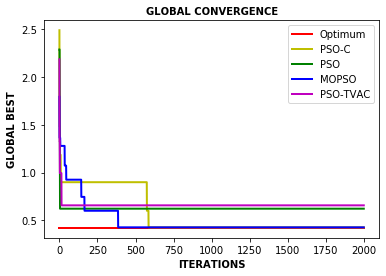

In [73]:
                                               # GBEST VS ITERATIONS


    
%matplotlib inline
import matplotlib.pyplot as plt
    
iterations = list(range(0,2001))
plt.title('GLOBAL CONVERGENCE', fontsize=10, fontweight='bold')
plt.xlabel('ITERATIONS', fontsize=10, fontweight='bold')
plt.ylabel('GLOBAL BEST', fontsize=10, fontweight='bold')
a = plt.plot([0,2000],[0.42,0.42], 'r-', label = 'Optimum', linewidth=2.0)
b = plt.plot(iterations,G_BEST,'y-',label = 'PSO-C', linewidth=2.0)
c = plt.plot(iterations,G_BEST2,'g-',label = 'PSO', linewidth=2.0)
d = plt.plot(iterations,G_BEST3,'b-',label = 'MOPSO', linewidth=2.0)
e = plt.plot(iterations,G_BEST4,'m-',label = 'PSO-TVAC', linewidth=2.0)
plt.legend()
plt.show()

In [62]:
a = [0.7218334617360803, 0.7915926831988597, 0.8575735931288071, 0.8346185031754537, 0.7399625058575446, 0.7387585620455267, 0.8797718005356823, 0.7592518656831867, 0.7987149144487405, 0.7735147072961083]
sum(a)

7.895592597105989

In [ ]:
                                         # BEHAVIOUS BASED TASK ALLOCATION


Rp = {0: [-0.2,0.05], 1: [-0.3,0.9], 2: [0.4,0.4], 3: [0.81,0.36], 4: [0.4,0.12], 5:[-0.6,0.5], 6:[0.7,0.65], 7:[-0.4,0.37], 8: [-0.05, 0.65], 9: [0.1,0.72]}

Tp = {0: [0.5,0.3], 1: [0.1,0.25], 2: [-0.5,0.64], 3: [0.54,0.45], 4: [0.48,0.57], 5: [-0.132,0.5], 6: [0.8,0.11], 7: [-0.65,0.2], 8: [-0.77,0.71], 9: [0.29,0.55]}

processing_capacity = [0.10, 0.17, 0.11, 0.08, 0.05, 0.15, 0.14, 0.17, 0.09, 0.15]

initial_battery_capacity = [1,1,1,1,1,1,1,1,1,1]

initial_distance_travelled = [0,0,0,0,0,0,0,0,0,0]

title1 = 'POSITION OF ROBOTS AND FIRST SET OF TASKS'

title2 = '1ST SET OF TASKS ALLOCATED TO THE ROBOTS'

pso(Rp,Tp,processing_capacity,title1,title2,initial_battery_capacity,initial_distance_travelled,failure= [])

#******************************************************************************************************************************

#print('\n2ND SET OF TASK ALLOCATION BEGINS ...........')

Tp = {0: [-0.8,0.4], 1: [-0.45,0.85], 2: [-0.38,0.14], 3:[0.15,0.42], 4: [-0.05,0.8], 5:[0.87,0.32], 6: [0.65,0.8], 7: [0.75,0.58], 8: [0.4,0.75], 9: [0.3,0.2]}

processing_capacity = [0.095, 0.18, 0.087, 0.12, 0.16, 0.15, 0.13, 0.11, 0.19, 0.05]

initial_battery_capacity = battery_capacity

initial_distance_travelled = distance_travelled

title1 = 'POSITION OF ROBOTS AND SECOND SET OF TASKS'

title2 = '2ND SET OF TASKS ALLOCATED TO THE ROBOTS'

pso(Rp,Tp,processing_capacity,title1,title2,initial_battery_capacity,initial_distance_travelled,failure = [6,2])

#*******************************************************************************************************************************